<a href="https://colab.research.google.com/github/joeann811/Trading-Strategies-b/blob/Trading-Strategies-b.ipynb/Trading_Strategies_(b).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trading Strategies (b)

In [ ]:
import numpy as np
import pandas as pd
import datetime as dt
from pylab import mpl, plt
import warnings

In [ ]:
warnings.simplefilter('ignore')
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
np.random.seed(1000)
%config InlineBackend.figure_format = 'svg'

In [ ]:
# Import dataset file from local drive
from google.colab import files
uploaded = files.upload()

Saving tr_eikon_eod_data.csv to tr_eikon_eod_data.csv


# Linear OLS Regression

The Data

In [ ]:
raw = pd.read_csv('tr_eikon_eod_data.csv',
                  index_col=0, parse_dates=True).dropna()

In [ ]:
raw.columns

Index(['AAPL.O', 'MSFT.O', 'INTC.O', 'AMZN.O', 'GS.N', 'SPY', '.SPX', '.VIX',
       'EUR=', 'XAU=', 'GDX', 'GLD'],
      dtype='object')

In [ ]:
symbol = 'EUR='

In [ ]:
data = pd.DataFrame(raw[symbol])

In [ ]:
data['returns'] = np.log(data / data.shift(1))

In [ ]:
data.dropna(inplace=True)

In [ ]:
data['direction'] = np.sign(data['returns']).astype(int)

In [ ]:
data.head()

,EUR=,returns,direction
Date,,,
2010-01-05,1.4368,-0.002988,-1
2010-01-06,1.4412,0.003058,1
2010-01-07,1.4318,-0.006544,-1
2010-01-08,1.4412,0.006544,1
2010-01-11,1.4513,0.006984,1


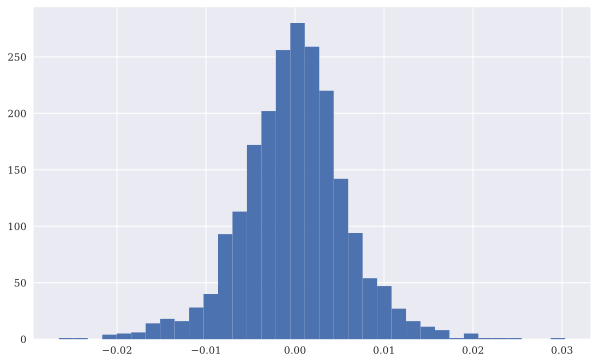

In [ ]:
data['returns'].hist(bins=35, figsize=(10, 6));

In [ ]:
lags = 2

In [ ]:
def create_lags(data):
    global cols
    cols = []
    for lag in range(1, lags + 1):
        col = 'lag_{}'.format(lag)
        data[col] = data['returns'].shift(lag)
        cols.append(col)

In [ ]:
create_lags(data)

In [ ]:
data.head()

,EUR=,returns,direction,lag_1,lag_2
Date,,,,,
2010-01-05,1.4368,-0.002988,-1,NaN,NaN
2010-01-06,1.4412,0.003058,1,-0.002988,NaN
2010-01-07,1.4318,-0.006544,-1,0.003058,-0.002988
2010-01-08,1.4412,0.006544,1,-0.006544,0.003058
2010-01-11,1.4513,0.006984,1,0.006544,-0.006544


In [ ]:
data.dropna(inplace=True)

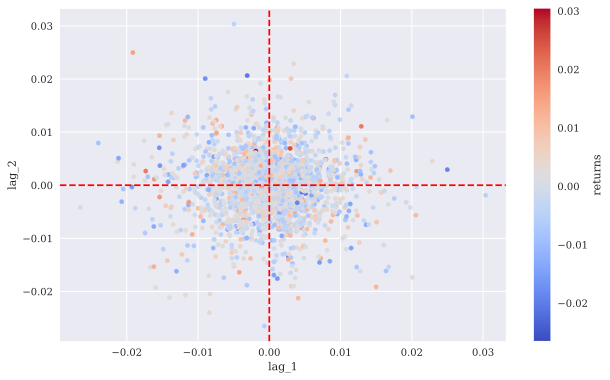

In [ ]:
data.plot.scatter(x='lag_1', y='lag_2', c='returns',
                  cmap='coolwarm', figsize=(10, 6), colorbar=True)
plt.axvline(0, c='r', ls='--')
plt.axhline(0, c='r', ls='--');

Regression

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
model = LinearRegression()

In [ ]:
data['pos_ols_1'] = model.fit(data[cols], data['returns']).predict(data[cols])

In [ ]:
data['pos_ols_2'] = model.fit(data[cols], data['direction']).predict(data[cols])

In [ ]:
data[['pos_ols_1', 'pos_ols_2']].head()

,pos_ols_1,pos_ols_2
Date,,
2010-01-07,-0.000166,-0.000086
2010-01-08,0.000017,0.040404
2010-01-11,-0.000244,-0.011756
2010-01-12,-0.000139,-0.043398
2010-01-13,-0.000022,0.002237


In [ ]:
data[['pos_ols_1', 'pos_ols_2']] = np.where(
            data[['pos_ols_1', 'pos_ols_2']] > 0, 1, -1)

In [ ]:
data['pos_ols_1'].value_counts()

-1    1847
 1     288
Name: pos_ols_1, dtype: int64

In [ ]:
data['pos_ols_2'].value_counts()

 1    1377
-1     758
Name: pos_ols_2, dtype: int64

In [ ]:
(data['pos_ols_1'].diff() != 0).sum()

555

In [ ]:
(data['pos_ols_2'].diff() != 0).sum()

762

In [ ]:
data['strat_ols_1'] = data['pos_ols_1'] * data['returns']

In [ ]:
data['strat_ols_2'] = data['pos_ols_2'] * data['returns']

In [ ]:
data[['returns', 'strat_ols_1', 'strat_ols_2']].sum().apply(np.exp)

returns        0.810644
strat_ols_1    0.942422
strat_ols_2    1.339286
dtype: float64

In [ ]:
(data['direction'] == data['pos_ols_1']).value_counts()

False    1093
True     1042
dtype: int64

In [ ]:
(data['direction'] == data['pos_ols_2']).value_counts()

True     1096
False    1039
dtype: int64

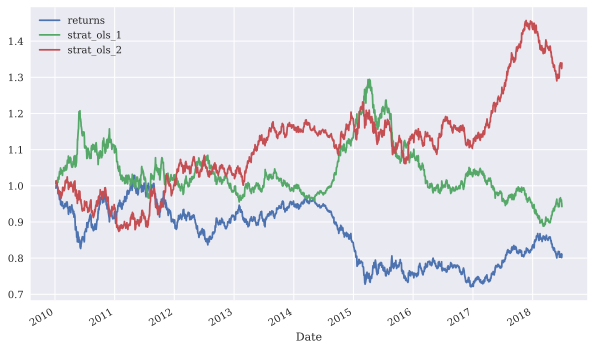

In [ ]:
data[['returns', 'strat_ols_1', 'strat_ols_2']].cumsum(
        ).apply(np.exp).plot(figsize=(10, 6));

# Clustering

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
model = KMeans(n_clusters=2, random_state=0)  #  <1>

In [ ]:
model.fit(data[cols])

KMeans(n_clusters=2, random_state=0)

In [ ]:
data['pos_clus'] = model.predict(data[cols])

In [ ]:
data['pos_clus'] = np.where(data['pos_clus'] == 1, -1, 1)

In [ ]:
data['pos_clus'].values

array([ 1, -1,  1, ..., -1, -1,  1])

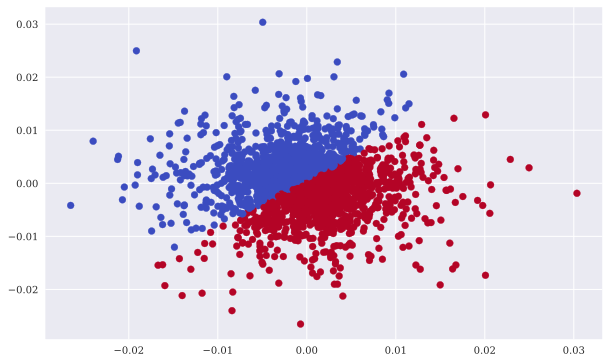

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(data[cols].iloc[:, 0], data[cols].iloc[:, 1],
            c=data['pos_clus'], cmap='coolwarm');

In [ ]:
data['strat_clus'] = data['pos_clus'] * data['returns']

In [ ]:
data[['returns', 'strat_clus']].sum().apply(np.exp)

returns       0.810644
strat_clus    0.787668
dtype: float64

In [ ]:
(data['direction'] == data['pos_clus']).value_counts()

False    1087
True     1048
dtype: int64

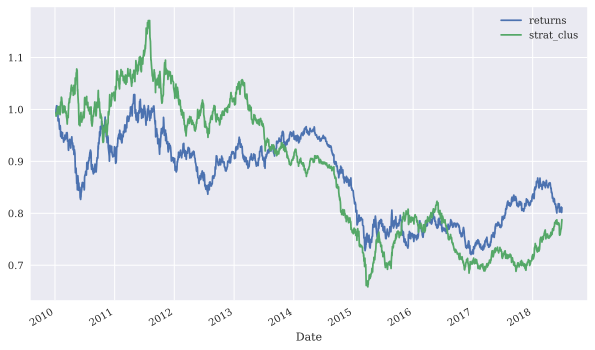

In [ ]:
data[['returns', 'strat_clus']].cumsum().apply(np.exp).plot(figsize=(10, 6));

# Frequency Approach

In [ ]:
def create_bins(data, bins=[0]):
    global cols_bin
    cols_bin = []
    for col in cols:
        col_bin = col + '_bin'
        data[col_bin] = np.digitize(data[col], bins=bins)
        cols_bin.append(col_bin)

In [ ]:
create_bins(data)

In [ ]:
data[cols_bin + ['direction']].head()

,lag_1_bin,lag_2_bin,direction
Date,,,
2010-01-07,1,0,-1
2010-01-08,0,1,1
2010-01-11,1,0,1
2010-01-12,1,1,-1
2010-01-13,0,1,1


In [ ]:
grouped = data.groupby(cols_bin + ['direction'])
grouped.size()

lag_1_bin  lag_2_bin  direction
0          0          -1           239
                       0             4
                       1           258
           1          -1           262
                       1           288
1          0          -1           272
                       0             1
                       1           278
           1          -1           278
                       0             4
                       1           251
dtype: int64

In [ ]:
res = grouped['direction'].size().unstack(fill_value=0)

In [ ]:
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

In [ ]:
res.style.apply(highlight_max, axis=1)

In [ ]:
data['pos_freq'] = np.where(data[cols_bin].sum(axis=1) == 2, -1, 1)

In [ ]:
(data['direction'] == data['pos_freq']).value_counts()

True     1102
False    1033
dtype: int64

In [ ]:
data['strat_freq'] = data['pos_freq'] * data['returns']

In [ ]:
data[['returns', 'strat_freq']].sum().apply(np.exp)

returns       0.810644
strat_freq    0.989513
dtype: float64

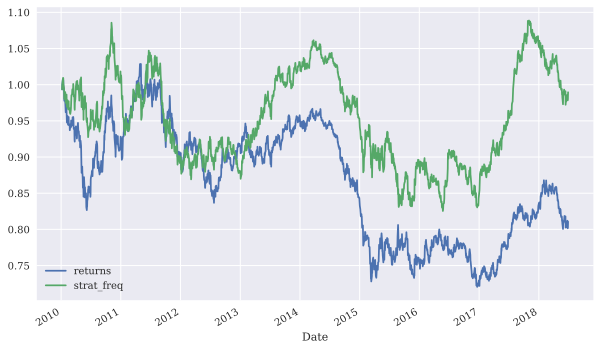

In [ ]:
data[['returns', 'strat_freq']].cumsum().apply(np.exp).plot(figsize=(10, 6));

# Classification Algorithhms

In [ ]:
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [ ]:
C = 1

In [ ]:
models = {
    'log_reg': linear_model.LogisticRegression(C=C),
    'gauss_nb': GaussianNB(),
    'svm': SVC(C=C)
}

In [ ]:
def fit_models(data):
    mfit = {model: models[model].fit(data[cols_bin], data['direction'])
            for model in models.keys()}

In [ ]:
fit_models(data)

In [ ]:
def derive_positions(data):
    for model in models.keys():
        data['pos_' + model] = models[model].predict(data[cols_bin])

In [ ]:
derive_positions(data)

In [ ]:
def evaluate_strats(data):
    global sel
    sel = []
    for model in models.keys():
        col = 'strat_' + model
        data[col] = data['pos_' + model] * data['returns']
        sel.append(col)
    sel.insert(0, 'returns')

In [ ]:
evaluate_strats(data)

In [ ]:
sel.insert(1, 'strat_freq')

In [ ]:
data[sel].sum().apply(np.exp)

returns           0.810644
strat_freq        0.989513
strat_log_reg     1.243322
strat_gauss_nb    1.243322
strat_svm         0.989513
dtype: float64

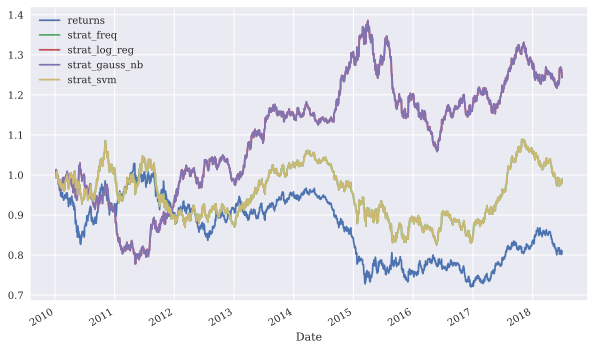

In [ ]:
data[sel].cumsum().apply(np.exp).plot(figsize=(10, 6));

In [ ]:
data = pd.DataFrame(raw[symbol])

In [ ]:
data['returns'] = np.log(data / data.shift(1))

In [ ]:
data['direction'] = np.sign(data['returns'])

In [ ]:
lags = 5
create_lags(data)
data.dropna(inplace=True)

In [ ]:
create_bins(data)
cols_bin

['lag_1_bin', 'lag_2_bin', 'lag_3_bin', 'lag_4_bin', 'lag_5_bin']

In [ ]:
data[cols_bin].head()

,lag_1_bin,lag_2_bin,lag_3_bin,lag_4_bin,lag_5_bin
Date,,,,,
2010-01-12,1,1,0,1,0
2010-01-13,0,1,1,0,1
2010-01-14,1,0,1,1,0
2010-01-15,0,1,0,1,1
2010-01-19,0,0,1,0,1


In [ ]:
data.dropna(inplace=True)

In [ ]:
fit_models(data)

In [ ]:
derive_positions(data)

In [ ]:
evaluate_strats(data)

In [ ]:
data[sel].sum().apply(np.exp)

returns           0.805002
strat_log_reg     0.971623
strat_gauss_nb    0.986420
strat_svm         2.649423
dtype: float64

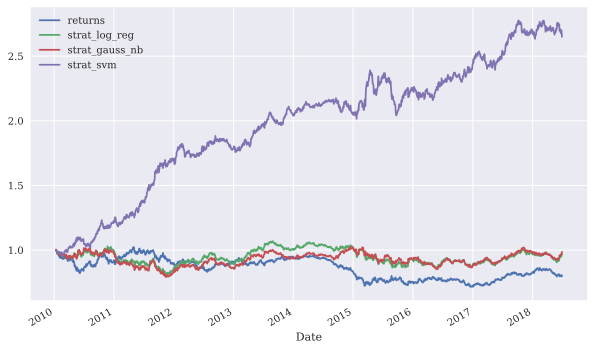

In [ ]:
data[sel].cumsum().apply(np.exp).plot(figsize=(10, 6));

In [ ]:
mu = data['returns'].mean()
v = data['returns'].std()

In [ ]:
bins = [mu - v, mu, mu + v]
bins

[-0.006033537040418664, -0.00010174015279231288, 0.005830056734834038]

In [ ]:
create_bins(data, bins)

In [ ]:
data[cols_bin].head()

,lag_1_bin,lag_2_bin,lag_3_bin,lag_4_bin,lag_5_bin
Date,,,,,
2010-01-12,3,3,0,2,1
2010-01-13,1,3,3,0,2
2010-01-14,2,1,3,3,0
2010-01-15,1,2,1,3,3
2010-01-19,0,1,2,1,3


In [ ]:
fit_models(data)

In [ ]:
derive_positions(data)

In [ ]:
evaluate_strats(data)

In [ ]:
data[sel].sum().apply(np.exp)

returns           0.805002
strat_log_reg     1.431120
strat_gauss_nb    1.815304
strat_svm         7.165290
dtype: float64

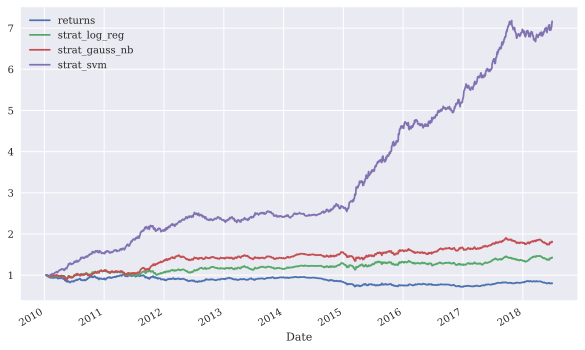

In [ ]:
data[sel].cumsum().apply(np.exp).plot(figsize=(10, 6));

# Deep Neural Network

DNN with scikit-learn

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

In [ ]:
model = MLPClassifier(solver='lbfgs', alpha=1e-5,
                     hidden_layer_sizes=2 * [250], random_state=1)

In [ ]:
%time model.fit(data[cols_bin], data['direction'])

CPU times: user 25.3 s, sys: 21.4 s, total: 46.7 s
Wall time: 27.3 s


MLPClassifier(alpha=1e-05, hidden_layer_sizes=[250, 250], random_state=1,
              solver='lbfgs')

In [ ]:
data['pos_dnn_sk'] = model.predict(data[cols_bin])

In [ ]:
data['strat_dnn_sk'] = data['pos_dnn_sk'] * data['returns']

In [ ]:
data[['returns', 'strat_dnn_sk']].sum().apply(np.exp)

returns          0.805002
strat_dnn_sk    37.656437
dtype: float64

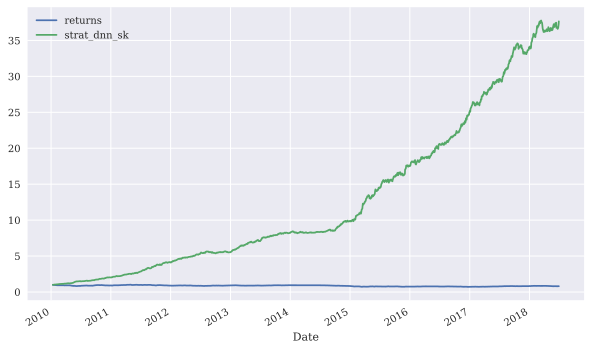

In [ ]:
data[['returns', 'strat_dnn_sk']].cumsum().apply(np.exp).plot(figsize=(10, 6));

In [ ]:
train, test = train_test_split(data, test_size=0.5, random_state=100)

In [ ]:
train = train.copy().sort_index()

In [ ]:
test = test.copy().sort_index()

In [ ]:
model = MLPClassifier(solver='lbfgs', alpha=1e-5, max_iter=500,
                     hidden_layer_sizes=3 * [500], random_state=1)

In [ ]:
%time model.fit(train[cols_bin], train['direction'])

CPU times: user 3min 21s, sys: 1min 49s, total: 5min 11s
Wall time: 3min 7s


MLPClassifier(alpha=1e-05, hidden_layer_sizes=[500, 500, 500], max_iter=500,
              random_state=1, solver='lbfgs')

In [ ]:
test['pos_dnn_sk'] = model.predict(test[cols_bin])

In [ ]:
test['strat_dnn_sk'] = test['pos_dnn_sk'] * test['returns']

In [ ]:
test[['returns', 'strat_dnn_sk']].sum().apply(np.exp)

returns         0.878078
strat_dnn_sk    1.055257
dtype: float64

<Axes: xlabel='Date'>

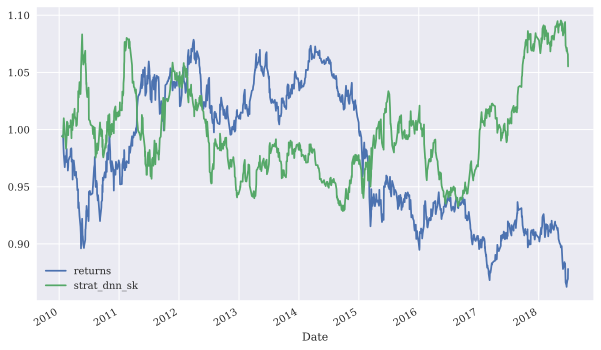

In [ ]:
test[['returns', 'strat_dnn_sk']].cumsum().apply(np.exp).plot(figsize=(10, 6));

DNN with Keras & TensoFlow Backend

In [ ]:
import tensorflow as tf
from keras.layers import Dense
from keras.models import Sequential

In [ ]:
def create_model():
    np.random.seed(100)
    tf.random.set_seed(100)
    model = Sequential()
    model.add(Dense(16, activation='relu', input_dim=lags))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='rmsprop',
                  metrics=['accuracy'])
    return model

In [ ]:
data_ = (data - data.mean()) / data.std()
data['direction_'] = np.where(data['direction'] == 1, 1, 0)

In [ ]:
model = create_model()

In [ ]:
%%time
model.fit(data_[cols], data['direction_'],
          epochs=50, verbose=False)

CPU times: user 5.85 s, sys: 272 ms, total: 6.12 s
Wall time: 10.3 s


In [ ]:
model.evaluate(data_[cols], data['direction_'])

67/67 [==============================] - 0s 1ms/step - loss: 0.6598 - accuracy: 0.5990


[0.6598057746887207, 0.5989680886268616]

In [ ]:
pred = np.where(model.predict(data_[cols]) > 0.5, 1, 0)
pred[:10].flatten()

67/67 [==============================] - 0s 1ms/step


array([0, 1, 0, 1, 0, 1, 1, 0, 1, 0])

In [ ]:
data['pos_dnn_ke'] = np.where(pred > 0, 1, -1)

In [ ]:
data['strat_dnn_ke'] = data['pos_dnn_ke'] * data['returns']

In [ ]:
data[['returns', 'strat_dnn_ke']].sum().apply(np.exp)

returns         0.805002
strat_dnn_ke    8.076275
dtype: float64

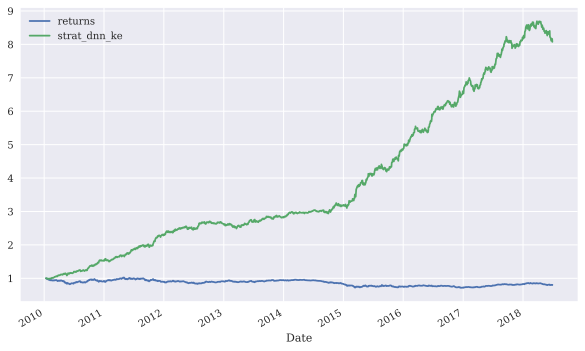

In [ ]:
data[['returns', 'strat_dnn_ke']].cumsum(
        ).apply(np.exp).plot(figsize=(10, 6));

In [ ]:
mu, std = train.mean(), train.std()

In [ ]:
train_ = (train - mu) / mu.std()

In [ ]:
model = create_model()

In [ ]:
train['direction_'] = np.where(train['direction'] > 0, 1, 0)

In [ ]:
%%time
model.fit(train_[cols], train['direction_'],
          epochs=50, verbose=False)

CPU times: user 4.63 s, sys: 136 ms, total: 4.77 s
Wall time: 6.06 s


In [ ]:
test_ = (test - mu) / std

In [ ]:
test['direction_'] = np.where(test['direction'] > 0, 1, 0)

In [ ]:
model.evaluate(test_[cols], test['direction_'])

34/34 [==============================] - 0s 2ms/step - loss: 0.8102 - accuracy: 0.4972


[0.8102161884307861, 0.49718573689460754]

In [ ]:
pred = np.where(model.predict(test_[cols]) > 0.5, 1, 0)
pred[:10].flatten()

34/34 [==============================] - 0s 1ms/step


array([0, 1, 1, 0, 0, 1, 1, 0, 0, 1])

In [ ]:
test['pos_dnn_ke'] = np.where(pred > 0, 1, -1)

In [ ]:
test['strat_dnn_ke'] = test['pos_dnn_ke'] * test['returns']

In [ ]:
test[['returns', 'strat_dnn_sk', 'strat_dnn_ke']].sum().apply(np.exp)

returns         0.878078
strat_dnn_sk    1.055257
strat_dnn_ke    0.972974
dtype: float64

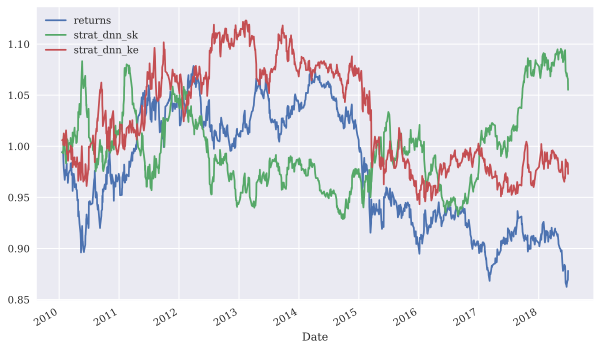

In [ ]:
test[['returns', 'strat_dnn_sk', 'strat_dnn_ke']].cumsum(
        ).apply(np.exp).plot(figsize=(10, 6));